# This notebook uses all the script to train a CAE for DNase

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
testing = False
    
# The base directory is one level up
base = '..'
settings_filepath = (
    '../settings-grch38-dnase-12kb-testing.json'
    if testing
    else '../settings-grch38-dnase-12kb.json'
)
cnn_search_filepath = '../cnn-search.json'
cnn_search_2_filepath = '../cnn-search-2.json'
optimizer_search_filepath = '../optimizer-search.json'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load settings

In [2]:
with open(settings_filepath, "r") as f:
    settings = json.load(f)

with open(cnn_search_filepath, "r") as f:
    cnn_search = json.load(f)

with open(cnn_search_2_filepath, "r") as f:
    cnn_search_2 = json.load(f)

with open(optimizer_search_filepath, "r") as f:
    optimizer_search = json.load(f)

### 1. Find DNase datasets on ENCODE

In [3]:
from find import find

datasets_filepath = find(settings, base=base, clear=False, verbose=True)

Search for experiments... done!
Found 727 human DNase-seq experiments
Download metadata... done!
Removed 586 experiments due to auditing errors
Found 120 experiments comprising 120 datasets
Saved dataset accessions to ../datasets-grch38-dnase-2019-02-16.json


In [4]:
# Comment out or remove the following line. It's only used for testing
# testing = True
datasets_filepath = '../datasets-grch38-dnase-testing.json' if testing else datasets_filepath
with open(datasets_filepath, "r") as f:
    datasets = json.load(f)
    dataset_ids = list(datasets.keys())

### 2. Download the datasets

In [80]:
from download import download

download(datasets, settings, base=base, clear=False, verbose=True)

The data will be downloaded to `../data`.

### 3. Create jobs for preparing all the datasets

In [20]:
from prepare import prepare_jobs

datasets_filepath = '../datasets-grch38-dnase-2019-02-16.json'

prepare_jobs(
    'DNase',
    os.path.relpath(datasets_filepath, base),
    os.path.relpath(settings_filepath, base),
    base=base,
    clear=False,
    verbose=False,
)

Created a slurm file for preparing 120 datasets


In [27]:
"""Check if all datasets have been prepared"""

import h5py

try:
    with open(os.path.join(base, "datasets-grch38-dnase-2019-02-16.json"), "r") as f:
        all_datasets = json.load(f).keys()
except FileNotFoundError:
    all_datasets = []
    print("Damn! Where is the file with the ENCODE experiments?")

not_found = []
outdated = []
total_size = 0

for dataset in all_datasets:
    filepath = os.path.join(base, 'data', '{}.h5'.format(dataset))
    total_size += os.path.getsize(filepath)
    try:
        with h5py.File(filepath, "r") as f:
            try:
                x = f['data_train']
                x = f['data_dev']
                x = f['data_test']
                x = f['peaks_train']
                x = f['peaks_dev']
                x = f['peaks_test']
                x = f['shuffling']
                x = f['settings']
            except KeyError:
                outdated.append(dataset)
    except OSError:
        not_found.append(dataset)

print("{} are not found".format(len(not_found)))
print("{} are not outdated".format(len(outdated)))

0 are not found
0 are not outdated


In [29]:
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

convert_size(total_size)

'37.06 GB'

Start preparation with `sbatch prepare.slurm`.

### 3.5 Test data preparation

In [5]:
from prepare import prepare

settings['incl_pctl_total_signal'] = 50
settings['incl_pct_no_signal'] = 5
settings['peak_ratio'] = 2

prepare(
    'DNase',
    datasets,
    settings,
    single_dataset='ENCSR320PGJ',
    base=base,
    clear=True,
    verbose=True,
)

Window size: 12000bp
Resolution: 100bp
Bins per window: 120
Step frequency per window: 2
Step size: 6000bp
Chromosomes: chr1, chr2, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chr20, chr21, chr22, chrX
Dev set size: 7.5%
Test set size: 7.5%
Percentile cut off: [0, 99.9]

Prepare dataset ENCSR320PGJ
Remove incomplete data to avoid inconsistencies
Extract windows from ENCFF915OOI.bigWig.......................
Extract narrow peaks from ENCFF734JDX.bigBed.......................
Extract broad peaks from ENCFF179DPX.bigBed.......................
Select windows to balance peaky and non-peaky ratio
Windows: total = 505160 | with peaks = 119866 | with signal gt 50 pctl = 73917
Train: 164715 (with 61.74% peaks) Dev: 14534 (with 62.61% peaks) Test: 14534 (with 62.41% peaks)
Saving... done!


Train data shape: (5698, 120, 1)
Train peaks shape: (5698,) num windows with peaks 2872 (50.40%)
Dev data shape: (503, 120, 1)
Dev peaks shape: (503,) num windows with peaks 238 (47.32%)
Test data shape: (503, 120, 1)
Test peaks shape: (503,) num windows with peaks 242 (48.11%)
88 (1.54%) out of 5698 windows are empty


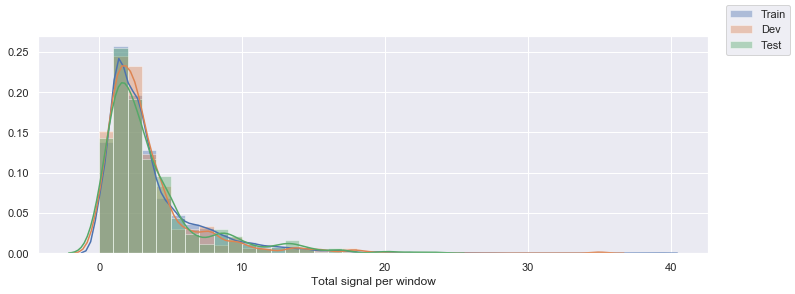

In [57]:
"""Sanity check that the normalization really worked"""

from ae.utils import plot_total_signal

plot_total_signal('ENCSR320PGJ', base=base)

In [13]:
"""Merge data for CNN search for speed"""

from merge import merge

try:
    with open(os.path.join(base, "datasets-grch38-dnase-cnn-search.json"), "r") as f:
        datasets_for_cnn_search = json.load(f)
except FileNotFoundError:
    print("Damn! Where is the file with the exxperiments for CNN search?")

if datasets_for_cnn_search:
    merge(
        datasets_for_cnn_search,
        settings,
        name='cnn-search',
        base=base,
        clear=False,
        verbose=False,
        dtype='float32'
    )

In [ ]:
"""Merge all 120 datasets for CNN training for speed"""

from merge import merge

try:
    with open(os.path.join(base, "datasets-grch38-dnase-2019-02-16.json"), "r") as f:
        all_datasets = json.load(f)
except FileNotFoundError:
    print("Damn! Where is the file with the experiments for CNN search?")

if all_datasets:
    merge(
        all_datasets,
        settings,
        name='grch38-dnase-2019-02-16',
        base=base,
        clear=False,
        verbose=False,
        dtype='float32'
    )

### 4. Create jobs for training various CAE models

In [10]:
from jobs import jobs

jobs(
    os.path.relpath(cnn_search_2_filepath, base),
    os.path.relpath(settings_filepath, base),
    dataset="cnn-search",
    name="cnn-search-2",
    cluster="seas",
    epochs=25,
    batch_size=1024,
    base=base,
    clear=True,
    verbose=False
)


Created slurm file for training 116 neural networks


### 5. Test CAEs training

In [6]:
from train import train

model_name = 'cf-32-64-128--ck-3-5-7--du-512-256-128--do-0-0-0-0-0-0--e-10--rl-0--o-adam--lr-0.01--lrd-0.0--l-smse-2--m-'

# Load the CAE definition, training settings, datasets, and define training parameters
with open('../models/{}.json'.format(model_name), 'r') as f:
    definition = json.load(f)

# Start the training
train(
    settings,
    dataset_ids,
    definition,
    epochs=2,
    batch_size=1024,
    peak_weight=2,
    signal_weighting='logn',
    signal_weighting_zero_point_percentage=0.02,
    base=base,
    clear=True
)

KeyboardInterrupt: 

In [36]:
from train import train_on_single_dataset

model_name = 'cf-32-64-128-256--ck-3-5-7-9--du---do-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-'
model_name = 'cf-1024-1024-1024-1024--ck-11-11-11-11--du---do-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-'

# Load the CAE definition, training settings, datasets, and define training parameters
with open('../models/{}.json'.format(model_name), 'r') as f:
    definition = json.load(f)

# Start the training
train_on_single_dataset(
    settings,
    'cnn-search',
    definition,
    epochs=2,
    batch_size=1024,
    peak_weight=2,
    signal_weighting='logn',
    signal_weighting_zero_point_percentage=0.02,
    base=base,
    clear=True,
    train_on_hdf5=False,
)

KeyboardInterrupt: 

#### Visualize training and validation loss

In [19]:
from evaluate import create_jobs

create_jobs(
    'cnn-search',
    dataset='cnn-search',
    cluster="seas",
    base=base,
    incl_dtw=False,
)

Created slurm file for evaluating 194 neural networks


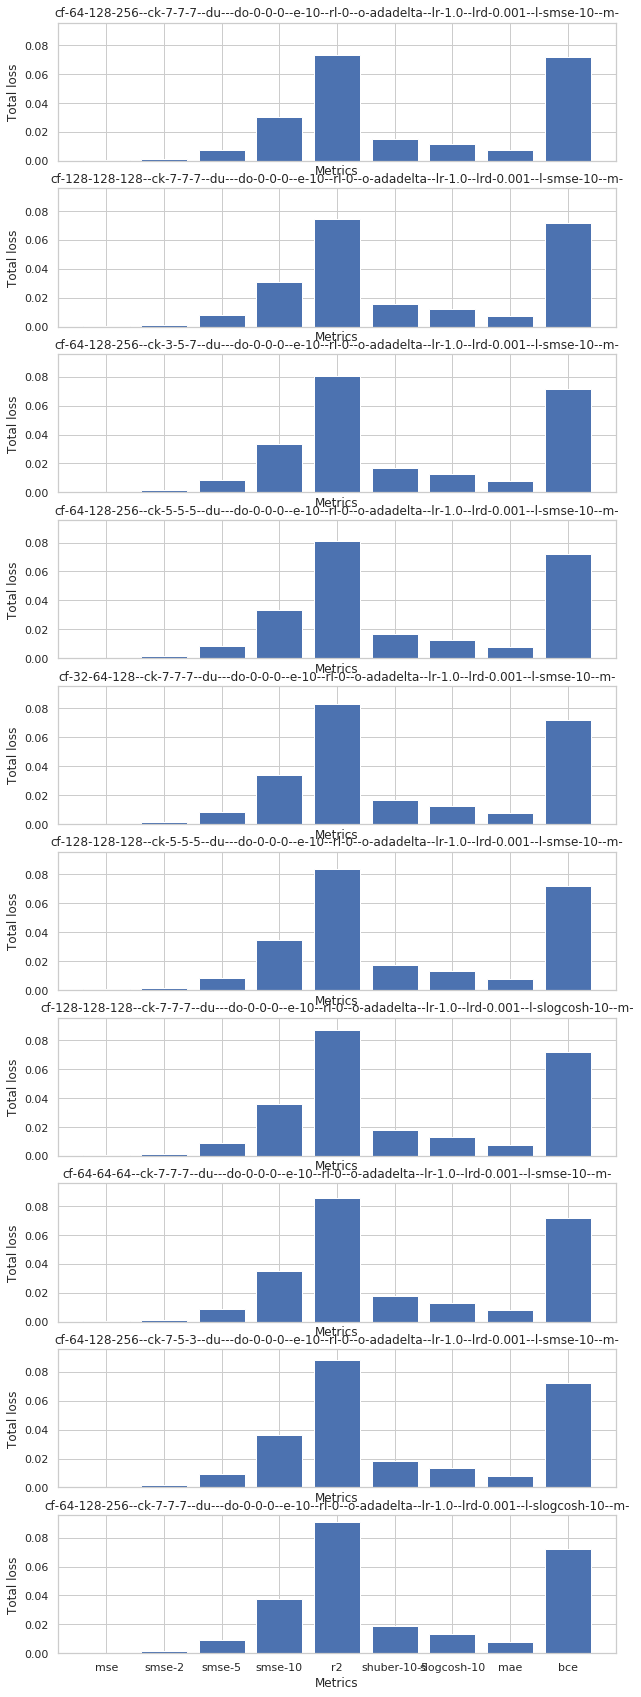

In [9]:
from compare import compare
    
losses = compare(
    'definitions-cnn-search.json',
    dataset_name='cnn-search',
    base=base,
    clear=False,
    verbose=False,
    silent=False,
    remove_common_prefix_from_df=True,
)

In [11]:
import qgrid

qgw = qgrid.show_grid(losses)
qgw

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### 6. Evaluate CAEs

In [ ]:
from evaluate import evaluate

model_name = 'cf-32-64-128--ck-3-5-7--du-512-256-128--do-0-0-0-0-0-0--e-10--rl-0--o-adam--lr-0.01--lrd-0.0--l-smse-2--m-'

evaluate(
    model_name,
    dataset_name='cnn-search',
    base=base,
    clear=True,
    silent=False,
    verbose=True,
    incl_dtw=False,
)

Evaluate: cf-32-64-128-256--ck-3-5-7-9--du---do-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-
Evaluate: cf-32-64-128-256--ck-9-7-5-3--du---do-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


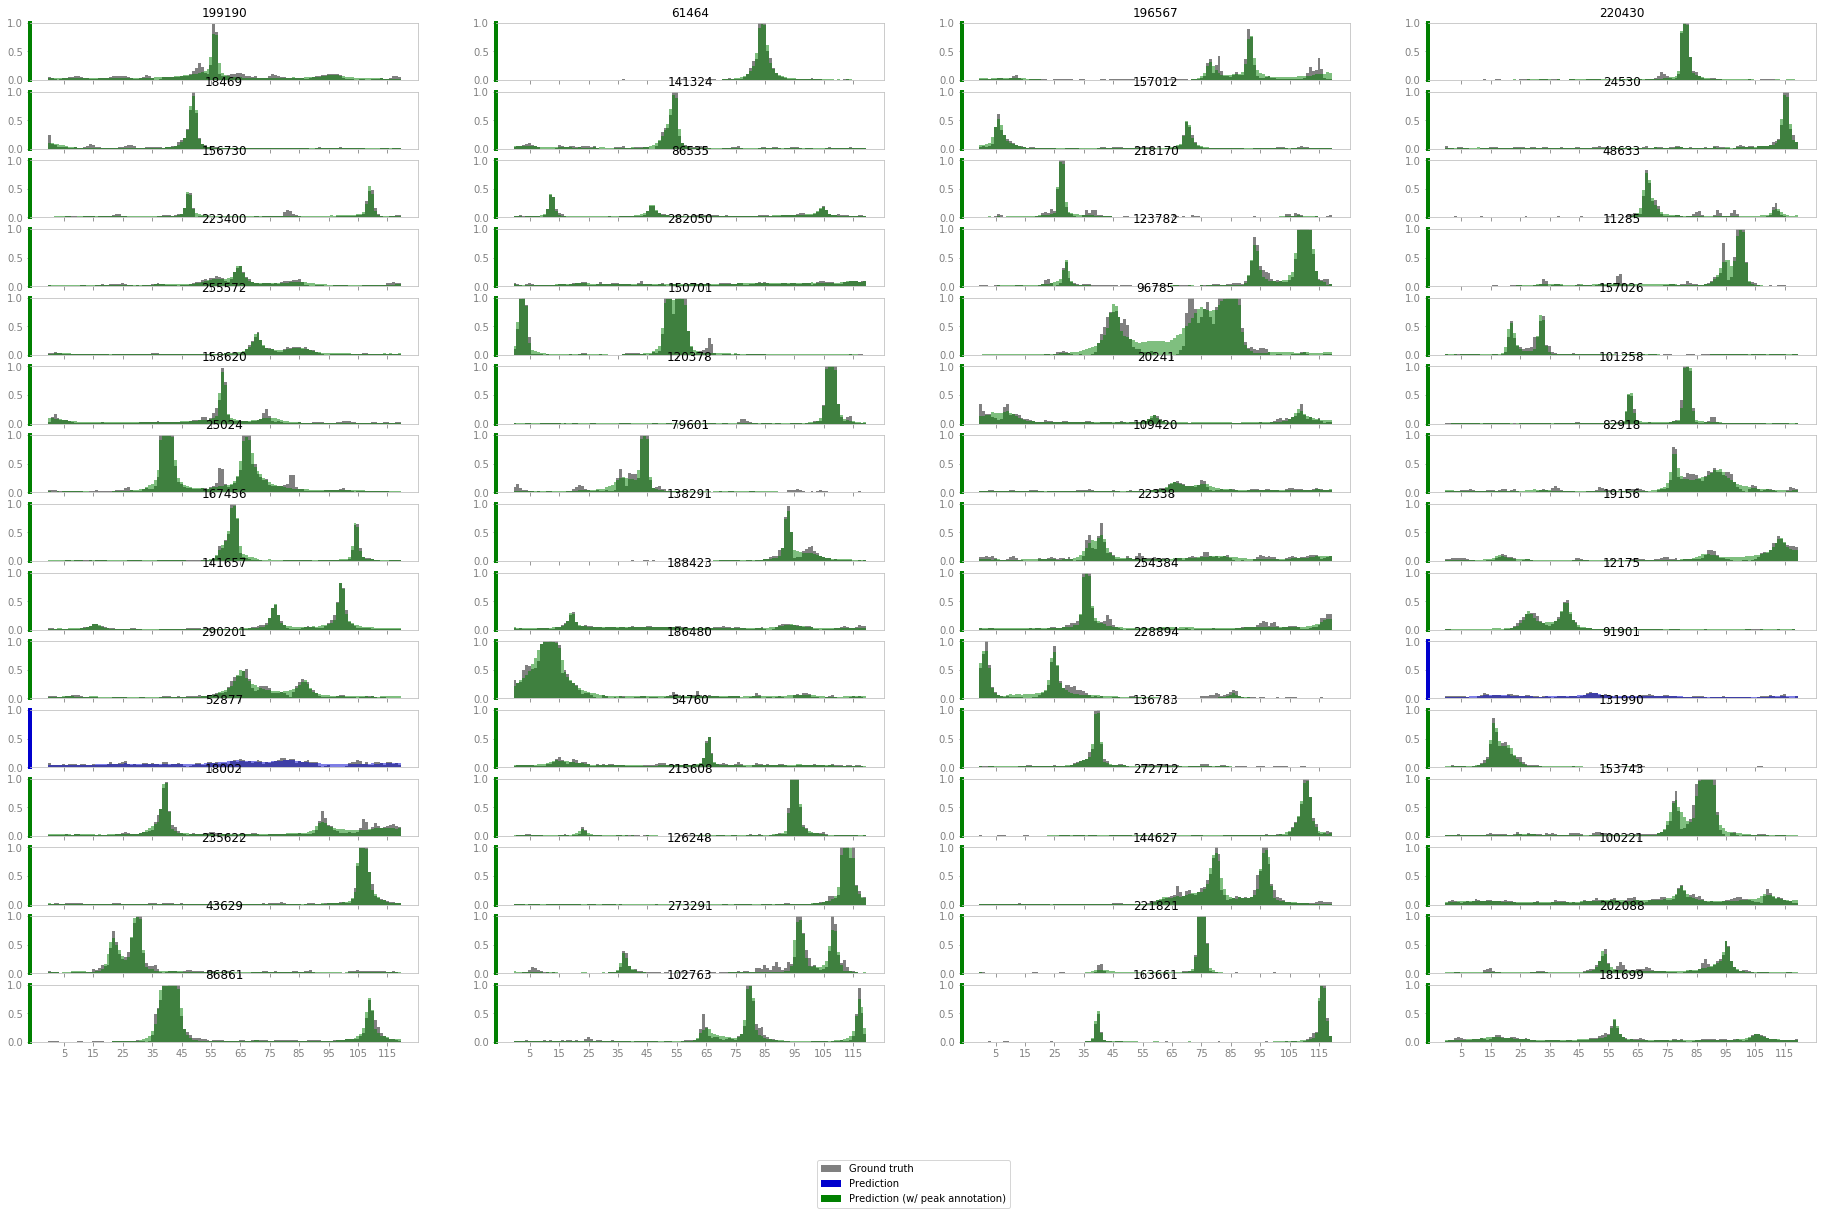

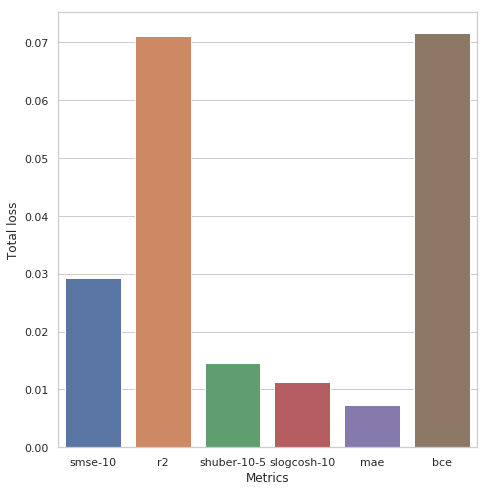

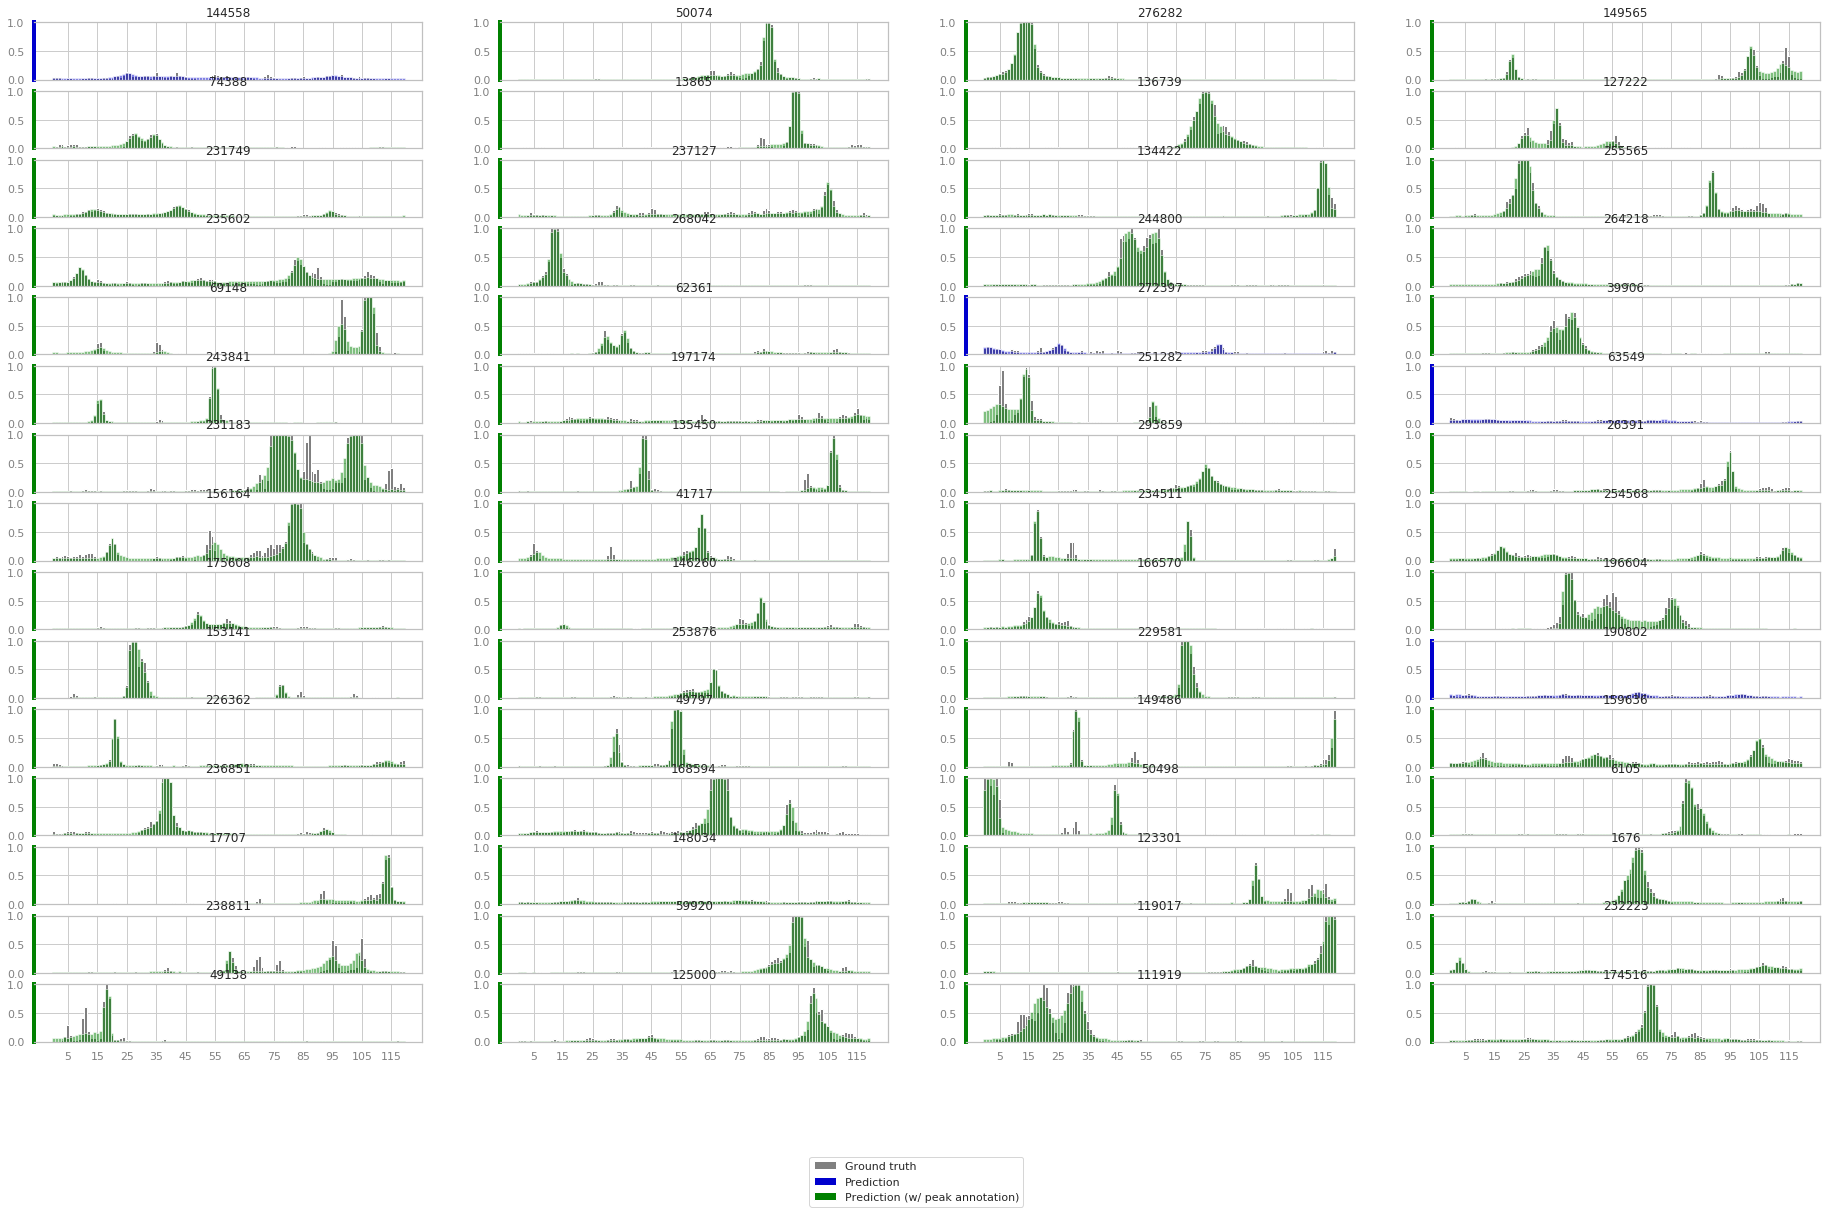

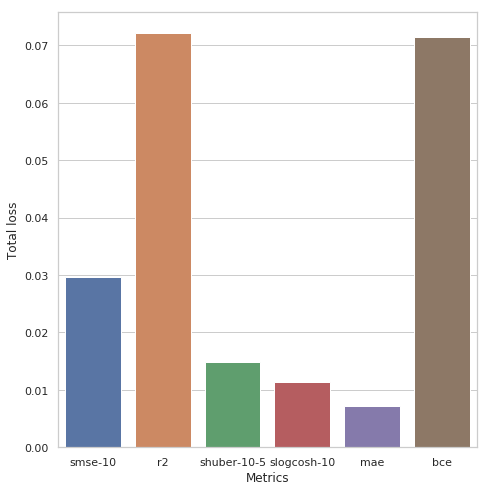

In [5]:
from evaluate import evaluate

model_names = [
    'cf-32-64-128-256--ck-3-5-7-9--du---do-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-',
    'cf-32-64-128-256--ck-9-7-5-3--du---do-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-',
]
    
for model_name in model_names:
    print('Evaluate: {}'.format(model_name))

    evaluate(
        model_name,
        dataset_name='cnn-search',
        base=base,
        clear=True,
        silent=True
    )

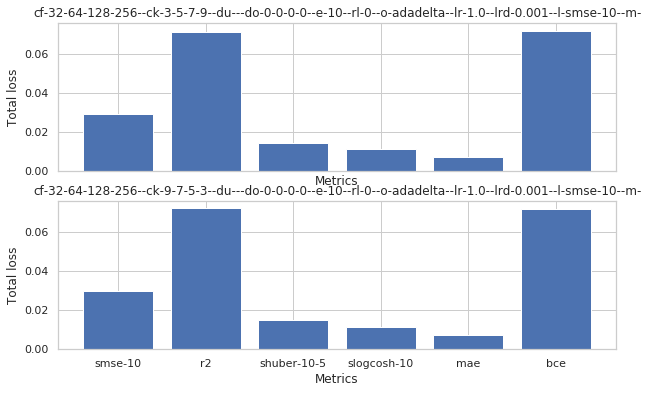

In [6]:
import json
import os

from compare import compare

# Store model_names
with open(os.path.join(base, "tmp-can-be-removed.json"), "w") as f:
    json.dump(model_names, f)

performance = compare(
    "tmp-can-be-removed.json",
    dataset_name="cnn-search",
    remove_common_prefix_from_df=True,
    base=base,
    clear=False,
)

In [8]:
import qgrid

qgw = qgrid.show_grid(performance)
qgw

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…